<a href="https://colab.research.google.com/github/singh-95/udacity_dog-breed-classifier/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# to read files from google drive, in case you're running on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = 'drive/My Drive/Pytorch_phase2/p2/'

!pip3 install face_recognition

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
    100% |████████████████████████████████| 100.2MB 179kB/s 
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


##  Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
# download the datasets and extract the zip files
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip dogImages.zip -d dog_images
!mv dog_images/dogImages/* dog_images/
!rm -r dog_images/dogImages
!unzip lfw.zip
!rm -f dogImages.zip lfw.zip
!rm -r __MACOSX

--2019-04-19 04:33:21--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.33
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  65.6MB/s    in 32s     

2019-04-19 04:33:53 (33.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

--2019-04-19 04:33:55--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.236.25
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.236.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196739509 (188M) [application/zip]
Saving to: ‘lfw.zip’

lfw.zip             100%[===================>

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [0]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

import face_recognition
import os
import torch
from torchvision import datasets, transforms

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path.
def face_detector(img_path):
    image = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=0, model="cnn")
    return len(face_locations) > 0

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
humans_detected_1 = 0
for each_link in human_files_short:
    if face_detector(each_link):
        humans_detected_1 += 1
        
humans_detected_2 = 0
for each_link in dog_files_short:
    if face_detector(each_link):
        humans_detected_2 += 1
        
print(humans_detected_1, humans_detected_2)

100 3


### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained resnet152 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 64

train_transforms = transforms.Compose([transforms.Resize(300),
                                transforms.RandomRotation(5),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(0.1),
                                transforms.RandomVerticalFlip(0.1),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('dog_images/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('dog_images/valid', transform=valid_transforms)
test_dataset = datasets.ImageFolder('dog_images/test', transform=valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

### (IMPLEMENTATION) Assess the Dog Detector

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, usingSGD=True):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            outputs = model(data)
            
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                outputs = model(data)
                
                loss = criterion(outputs, target)
                valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
         
        if(usingSGD):
            lr_scheduler.step(valid_loss_min)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if(valid_loss < valid_loss_min):
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model

In [0]:
# use transfer learning to train vgg16 for higher accuracy at detecting dogs
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict

vgg16_transfer = models.vgg16(pretrained=True)
for param in vgg16_transfer.parameters():
    param.requires_grad = False
    
classifier_name, old_classifier = vgg16_transfer._modules.popitem()
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(old_classifier[0].in_features, 4096)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(0.7)),
                                        ('fc2', nn.Linear(4096, 4096)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(0.5)),
                                        ('output', nn.Linear(4096, 1))
                                           ]))
vgg16_transfer.add_module(classifier_name, classifier)
#print(vgg16_transfer)
use_cuda = torch.cuda.is_available()
if use_cuda:
    vgg16_transfer = vgg16_transfer.cuda()

In [0]:
# specifying loss function and optimizer
loss_dog = lambda output, _ : torch.mean((output-1)**2) 
optimizer_dog = optim.Adam(vgg16_transfer.parameters(), lr=0.000001)

# train the model
vgg16_transfer = train(10, loaders, vgg16_transfer, optimizer_dog, loss_dog, use_cuda, 'model_dog.pt', False)

In [0]:
# load the model that got the best validation accuracy
vgg16_transfer.load_state_dict(torch.load(data_dir+'saved_models/model_dog.pt'))

In [0]:
!cp -f 'model_dog.pt' 'drive/My Drive/Pytorch_phase2/p2/saved_models/model_dog_020.pt'

In [0]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''   
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to resnet152 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    image = Image.open(img_path)
    t1 = transforms.RandomResizedCrop(224)
    t2 = transforms.ToTensor()
    t3 = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    image = t1(image)
    image = t2(image)
    image = t3(image)
    image = image.unsqueeze(0)
    if use_cuda:
        image = image.cuda()
    #print(image.shape)
    vgg16_transfer.eval()
    output = vgg16_transfer(image)
        
    #print(output)
    return output

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    output = VGG16_predict(img_path)
    #print(output)
    return output > 0.5 # true/false

In [0]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_detected = 0
for pic in human_files_short:
    if dog_detector(pic):
        dogs_detected += 1
print(dogs_detected, 'dogs detected in', len(human_files_short), 'human images')

dogs_detected = 0
for pic in dog_files_short:
    if dog_detector(pic):
        dogs_detected += 1
print(dogs_detected, 'dogs detected in', len(dog_files_short), 'dog images')

87 dogs detected in 100 human images
100 dogs detected in 100 dog images


## Create a CNN to Classify Dog Breeds (using Transfer Learning)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [0]:
# testing using transfer learning with vgg16 instead of resnet152
'''model_transfer = models.vgg16(pretrained=True)
    
classifier_name, old_classifier = model_transfer._modules.popitem()
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(old_classifier[0].in_features, 4096)),
                                        ('relu1', nn.ReLU()),
                                        ('drop1', nn.Dropout(0.6)),
                                        ('fc2', nn.Linear(4096, 4096)),
                                        ('relu2', nn.ReLU()),
                                        ('drop2', nn.Dropout(0.5)),
                                        ('output', nn.Linear(4096, 133))
                                           ]))
model_transfer.add_module(classifier_name, classifier)
#print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()'''

In [0]:
model_transfer = models.resnet152(pretrained=True)
'''ct = 0
for child in model_transfer.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False'''
    
classifier_name, old_classifier = model_transfer._modules.popitem()
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(old_classifier.in_features, 133))]))
model_transfer.add_module(classifier_name, classifier)
if use_cuda:
    model_transfer = model_transfer.cuda()
#model_transfer

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
# original values: lr = 0.09, momentum = 0.9
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), 0.01, momentum = 0.7)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_transfer, mode='min', factor=0.1, patience=2)
n_epochs = 100

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
# train the model
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

NameError: ignored

In [0]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(data_dir+'saved_models/model_transfer_89.pt'))

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.697520


Test Accuracy: 89% (749/836)


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
!cp -f 'model_transfer.pt' 'drive/My Drive/Pytorch_phase2/p2/saved_models/model_transfer_89.pt'

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is psredicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    global model_transfer
    image = Image.open(img_path)
    t1 = transforms.Resize(256)
    t2 = transforms.CenterCrop(224)
    t3 = transforms.ToTensor()
    t4 = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    image = t4(t3(t2(t1(image))))
    image = image.unsqueeze(0)
    if(use_cuda):
        image = image.cuda()
        model_transfer = model_transfer.cuda()
    #print('lol what\'s happening')
    model_transfer.eval()
    output_list = model_transfer(image).tolist()[0]
    #print(output_list)
    max_value = max(output_list)
        
    #print(output)
    return class_names[output_list.index(max_value)]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    if dog_detector(img_path) and not face_detector(img_path):
        print("You have been visited by the good luck bringing doggo, your lucky breed is...\n", predict_breed_transfer(img_path))
        
    elif face_detector(img_path):
        print("Aaaaand your spirit animal is...\n", predict_breed_transfer(img_path))
    else:
        print("bruh! with right data comes right output, without, error messages")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

In [0]:
for file in np.hstack((human_files[69:72], dog_files[69:72])):
    run_app(file)

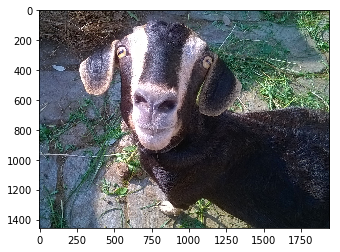

You have been visited by the good luck bringing doggo, your lucky breed is...
 Tibetan mastiff


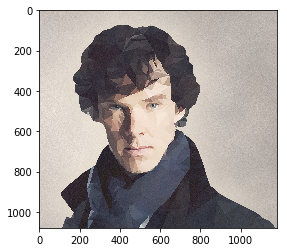

Aaaaand your spirit animal is...
 Black russian terrier


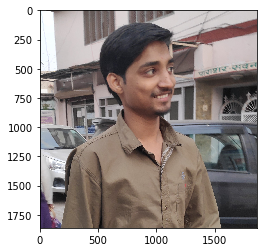

Aaaaand your spirit animal is...
 Silky terrier


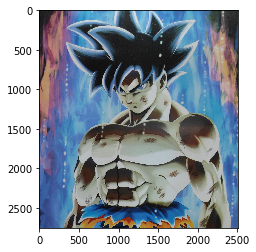

Aaaaand your spirit animal is...
 Beagle


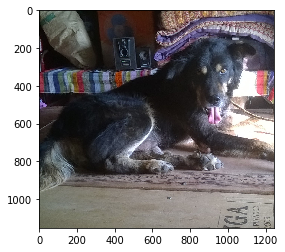

You have been visited by the good luck bringing doggo, your lucky breed is...
 Tibetan mastiff


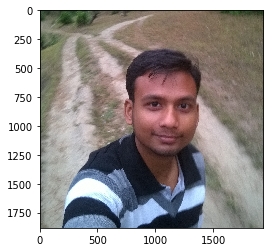

Aaaaand your spirit animal is...
 Japanese chin


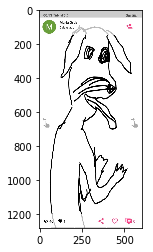

You have been visited by the good luck bringing doggo, your lucky breed is...
 Italian greyhound


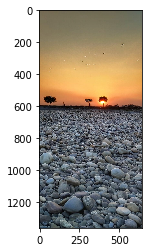

You have been visited by the good luck bringing doggo, your lucky breed is...
 Glen of imaal terrier


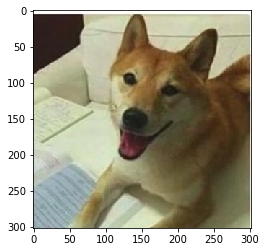

You have been visited by the good luck bringing doggo, your lucky breed is...
 Canaan dog


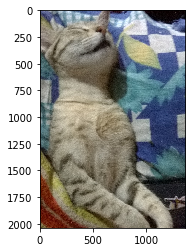

You have been visited by the good luck bringing doggo, your lucky breed is...
 Alaskan malamute


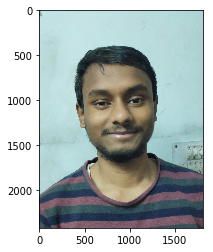

Aaaaand your spirit animal is...
 Silky terrier


In [0]:
#testing the algorithm on images from my pc
local_images = os.listdir(data_dir+'local_images')
for each_image in local_images:
    if not each_image.startswith('.'):
        run_app(data_dir+'local_images/'+each_image)


In [0]:
# this is where I do all the github thingy, this and all the cells from here on
import os

os.chdir('content/sample_data')

FileNotFoundError: ignored

In [0]:
!git config --global user.email "singhamitch@gmail.com"
!git config --global user.name "Amit Singh"
!git remote set-url origin git@github.com:singh-95/udacity_dog-breed-classifier

In [0]:
!ssh -i 'rsakey' -vT git@github.com
!ssh-keygen -R hostname

OpenSSH_7.6p1 Ubuntu-4ubuntu0.3, OpenSSL 1.0.2n  7 Dec 2017
debug1: Reading configuration data /etc/ssh/ssh_config
debug1: /etc/ssh/ssh_config line 19: Applying options for *
debug1: Connecting to github.com [192.30.253.113] port 22.
debug1: Connection established.
debug1: permanently_set_uid: 0/0
debug1: identity file rsakey type 0
debug1: key_load_public: No such file or directory
debug1: identity file rsakey-cert type -1
debug1: Local version string SSH-2.0-OpenSSH_7.6p1 Ubuntu-4ubuntu0.3
debug1: Remote protocol version 2.0, remote software version babeld-873429c4
debug1: no match: babeld-873429c4
debug1: Authenticating to github.com:22 as 'git'
debug1: SSH2_MSG_KEXINIT sent
debug1: SSH2_MSG_KEXINIT received
debug1: kex: algorithm: curve25519-sha256
debug1: kex: host key algorithm: rsa-sha2-512
debug1: kex: server->client cipher: chacha20-poly1305@openssh.com MAC: <implicit> compression: none
debug1: kex: client->server cipher: chacha20-poly1305@openssh.com MAC: <implicit> compressi

In [0]:
!ssh-add ~/.ssh/id_rsa

Could not open a connection to your authentication agent.


In [0]:
!ls
!xclip -sel clip < 'rsakey.pub'

dog_app.ipynb  images	     README.md	rsakey.pub
haarcascades   local_images  rsakey	saved_models
Error: Can't open display: (null)
